In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [32]:
from utils.dataloader import make_datapath_list, DataTransform, VOCDataset
# import DataLoader

rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))


In [33]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

state_dict = torch.load("./weights/pspnet50_30.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

<All keys matched successfully>

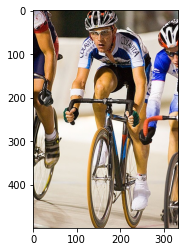

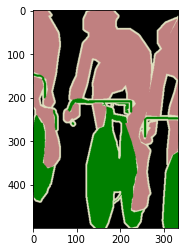

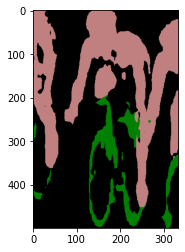

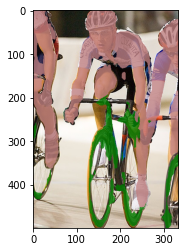

In [34]:
img_index = 4

image_file_path = val_img_list[img_index]
img_original = Image.open(image_file_path)
img_width, img_height = img_original.size
plt.imshow(img_original)
plt.show()

anno_file_path = val_anno_list[img_index]
anno_class_img = Image.open(anno_file_path)
p_palette = anno_class_img.getpalette()
plt.imshow(anno_class_img)
plt.show()

net.eval()
img, anno_class_img = val_dataset.__getitem__(img_index)
x = img.unsqueeze(0)
outputs = net(x)
y = outputs[0]  # Ignore AuxLoss

y = y[0].detach().numpy()
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')

for x in range(img_width):
    for y in range(img_height):
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            trans_img.putpixel((x, y), (r, g, b, 200))

result = Image.alpha_composite(img_original.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()
